In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy.optimize import fsolve

In [37]:
# For reproducibility
np.random.seed(42)

# Sample sizes to test
sample_sizes = [20, 50, 100]

# Parameters for the two distributions
normal_params = {'mean': 80, 'std': 20}
hyper_params = {'mean': 220, 'std': 50}

# Step 1: Create datasets outside the loop
datasets = {}  # Dictionary to store datasets keyed by sample size

for n in sample_sizes:
    normal_data = np.random.normal(loc=normal_params['mean'], scale=normal_params['std'], size=n//2)
    hyper_data = np.random.normal(loc=hyper_params['mean'], scale=hyper_params['std'], size=n//2)
    glucose_values = np.concatenate([normal_data, hyper_data]).reshape(-1, 1)
    datasets[n] = glucose_values  # Store for later use


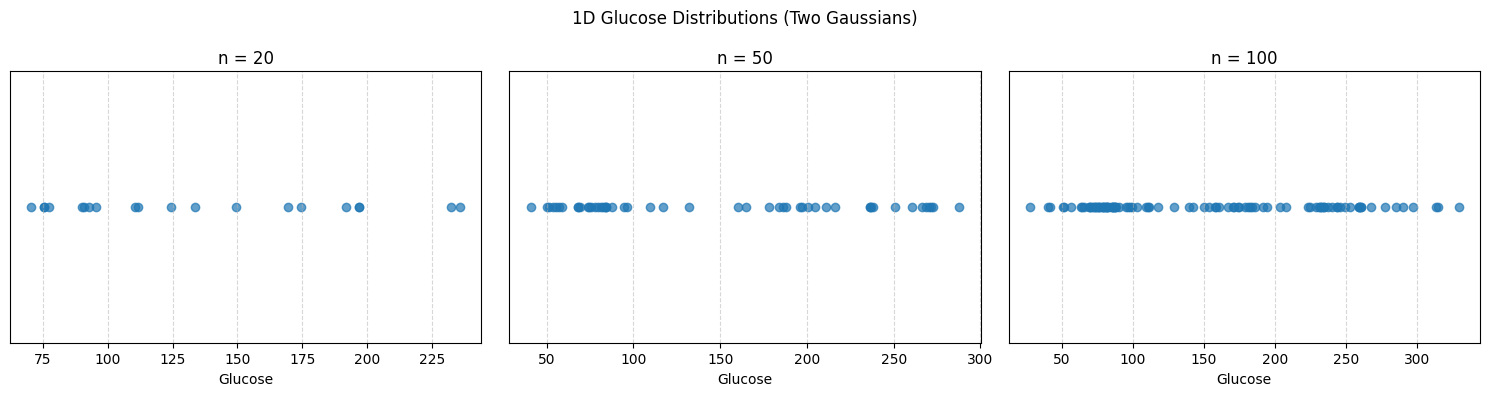

In [38]:
fig, axs = plt.subplots(1, len(sample_sizes), figsize=(15, 4), sharey=True)

for i, n in enumerate(sample_sizes):
    data = datasets[n]
    axs[i].scatter(data, np.ones_like(data), alpha=0.7)
    axs[i].set_title(f"n = {n}")
    axs[i].set_xlabel("Glucose")
    axs[i].set_yticks([])  # Hide y-axis
    axs[i].grid(True, axis='x', linestyle='--', alpha=0.5)

plt.suptitle("1D Glucose Distributions (Two Gaussians)")
plt.tight_layout()
plt.show()


In [39]:
def gaussian_pdf(x, mean, var):
    coeff = 1.0 / np.sqrt(2 * np.pi * var)
    exponent = np.exp(- (x - mean) ** 2 / (2 * var))
    return coeff * exponent

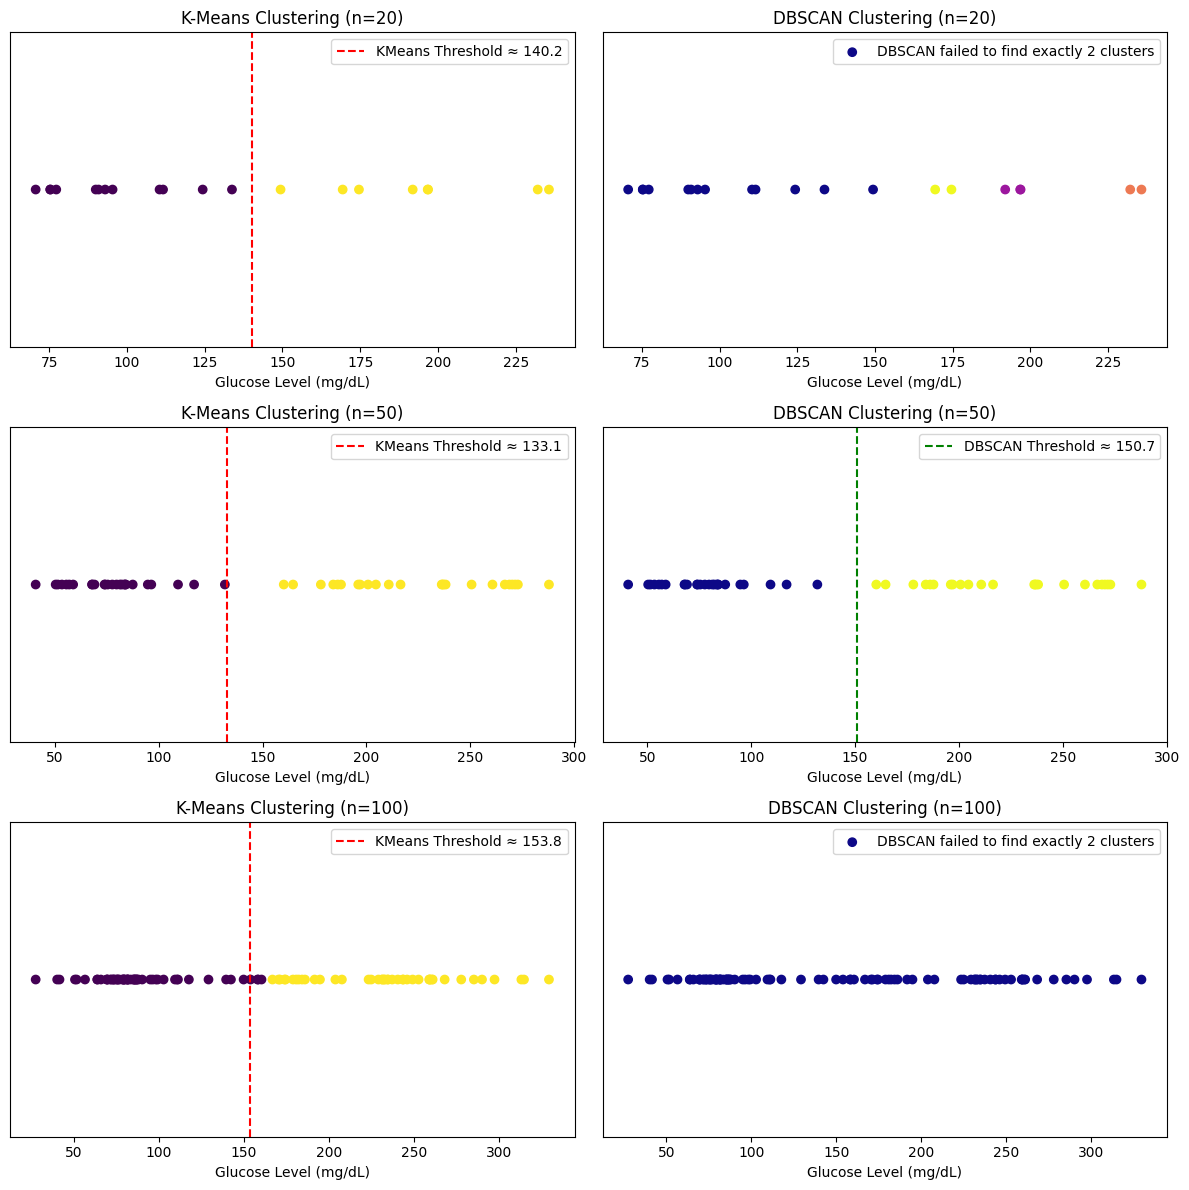

In [40]:
def find_intersection(mu1, sigma1, w1, mu2, sigma2, w2):
    def equation(x):
        return w1 * norm.pdf(x, mu1, sigma1) - w2 * norm.pdf(x, mu2, sigma2)
    x0 = (mu1 + mu2) / 2
    return fsolve(equation, x0)[0]


fig, axes = plt.subplots(len(sample_sizes), 2, figsize=(12, 12))

for i, n in enumerate(sample_sizes):
    glucose_values = datasets[n]
    glucose_values = glucose_values.reshape(-1, 1)

    # ----------------- KMeans -----------------
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans_labels = kmeans.fit_predict(glucose_values)

    cluster0 = glucose_values[kmeans_labels == 0]
    cluster1 = glucose_values[kmeans_labels == 1]
    mu0, sigma0 = cluster0.mean(), cluster0.std()
    mu1, sigma1 = cluster1.mean(), cluster1.std()
    w0 = len(cluster0) / len(glucose_values)
    w1 = len(cluster1) / len(glucose_values)

    threshold_kmeans = find_intersection(mu0, sigma0, w0, mu1, sigma1, w1)

    # Plot KMeans
    axes[i, 0].scatter(glucose_values, np.zeros_like(glucose_values), c=kmeans_labels, cmap='viridis')
    axes[i, 0].axvline(threshold_kmeans, color='red', linestyle='--', label=f"KMeans Threshold ≈ {threshold_kmeans:.1f}")
    axes[i, 0].set_title(f'K-Means Clustering (n={n})')
    axes[i, 0].set_xlabel('Glucose Level (mg/dL)')
    axes[i, 0].set_yticks([])
    axes[i, 0].legend()

    # ----------------- DBSCAN -----------------
    scaler = StandardScaler()
    glucose_scaled = scaler.fit_transform(glucose_values)

    dbscan = DBSCAN(eps=0.3, min_samples=2)
    dbscan_labels = dbscan.fit_predict(glucose_scaled)

    axes[i, 1].scatter(glucose_values, np.zeros_like(glucose_values), c=dbscan_labels, cmap='plasma')
    axes[i, 1].set_title(f'DBSCAN Clustering (n={n})')
    axes[i, 1].set_xlabel('Glucose Level (mg/dL)')
    axes[i, 1].set_yticks([])

    # DBSCAN Threshold (if exactly 2 clusters)
    unique_clusters = np.unique(dbscan_labels)
    unique_clusters = unique_clusters[unique_clusters != -1]  # ignore noise

    if len(unique_clusters) == 2:
        cluster_means = []
        for cluster_id in unique_clusters:
            cluster_points = glucose_values[dbscan_labels == cluster_id]
            cluster_mean = cluster_points.mean()
            cluster_means.append(cluster_mean)
        cluster_means.sort()
        threshold_dbscan = (cluster_means[0] + cluster_means[1]) / 2

        axes[i, 1].axvline(threshold_dbscan, color='green', linestyle='--', label=f"DBSCAN Threshold ≈ {threshold_dbscan:.1f}")
        axes[i, 1].legend()
    else:
        axes[i, 1].legend(["DBSCAN failed to find exactly 2 clusters"])

plt.tight_layout()
plt.show()


In [41]:
# 1. Initialize parameters
def initialize_params(X):
    means = np.random.choice(X, 2, replace=False)
    variances = [np.var(X)] * 2
    weights = [0.5, 0.5]
    return np.array(means), np.array(variances), np.array(weights)

# 2. E-step
def expectation_step(X, means, variances, weights):
    n = len(X)
    responsibilities = np.zeros((n, 2))
    for k in range(2):
        # responsibilities[:, k] = weights[k] * norm.pdf(X, means[k], np.sqrt(variances[k]))
        responsibilities[:, k] = weights[k] * gaussian_pdf(X, means[k], variances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

# 3. M-step
def maximization_step(X, responsibilities):
    Nk = responsibilities.sum(axis=0)
    means = (responsibilities * X[:, np.newaxis]).sum(axis=0) / Nk
    variances = ((responsibilities * (X[:, np.newaxis] - means) ** 2).sum(axis=0)) / Nk
    weights = Nk / len(X)
    return means, variances, weights

# 4. Threshold computation
def find_intersection(mu1, sigma1, w1, mu2, sigma2, w2):
    def equation(x):
        return w1 * norm.pdf(x, mu1, sigma1) - w2 * norm.pdf(x, mu2, sigma2)
    x0 = (mu1 + mu2) / 2
    return fsolve(equation, x0)[0]

# 5. EM Loop with threshold delta tolerance
def run_gmm(X, max_iters=100, tol=1e-6):
    means, variances, weights = initialize_params(X)
    prev_threshold = None

    for _ in range(max_iters):
        responsibilities = expectation_step(X, means, variances, weights)
        means, variances, weights = maximization_step(X, responsibilities)

        # Find current threshold
        mu1, mu2 = means
        sigma1, sigma2 = np.sqrt(variances)
        w1, w2 = weights
        threshold = find_intersection(mu1, sigma1, w1, mu2, sigma2, w2)

        # Convergence check based on threshold
        if prev_threshold is not None and abs(threshold - prev_threshold) < tol:
            break
        prev_threshold = threshold

    return means, variances, weights, responsibilities, threshold

# 6. Final label assignment
def assign_labels(responsibilities):
    return np.argmax(responsibilities, axis=1)


In [ ]:
def plot_gmm_results(X, labels, means, variances, weights, threshold):
    colors = ['tab:blue', 'tab:orange']
    label1 = ['Normal Glucose', 'Hyperglycemia']
    x_range = np.linspace(min(X) - 1, max(X) + 1, 500)

    # Sort components by mean to match labels correctly
    sort_idx = np.argsort(means)
    means = np.array(means)[sort_idx]
    variances = np.array(variances)[sort_idx]
    weights = np.array(weights)[sort_idx]

    # Reassign labels according to sorted means
    new_labels = np.zeros_like(labels)
    for new_k, original_k in enumerate(sort_idx):
        new_labels[labels == original_k] = new_k
    labels = new_labels

    # Create bigger figure
    plt.figure(figsize=(10, 6))  # Adjust size here

    # Plot data points with labels
    for k in range(2):
        plt.scatter(X[labels == k], [0.02] * np.sum(labels == k), 
                    color=colors[k], label=label1[k], alpha=0.6)

    # Plot Gaussians
    for k in range(2):
        pdf = weights[k] * norm.pdf(x_range, means[k], np.sqrt(variances[k]))
        plt.plot(x_range, pdf, color=colors[k], linestyle='-', lw=2, label=f'Gaussian {k}')

    # Plot threshold
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')

    # Annotate the threshold value
    plt.text(threshold, plt.ylim()[1]*0.9, f'Thresh ≈ {threshold:.2f}', 
             color='red', ha='left', va='top', fontsize=10, fontweight='bold')

    plt.title(r'GMM Results with Labels and Threshold (n = %d)' % len(X))
    plt.xlabel('Glucose Level (mg/dL)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Plotting GMM results for n = 20


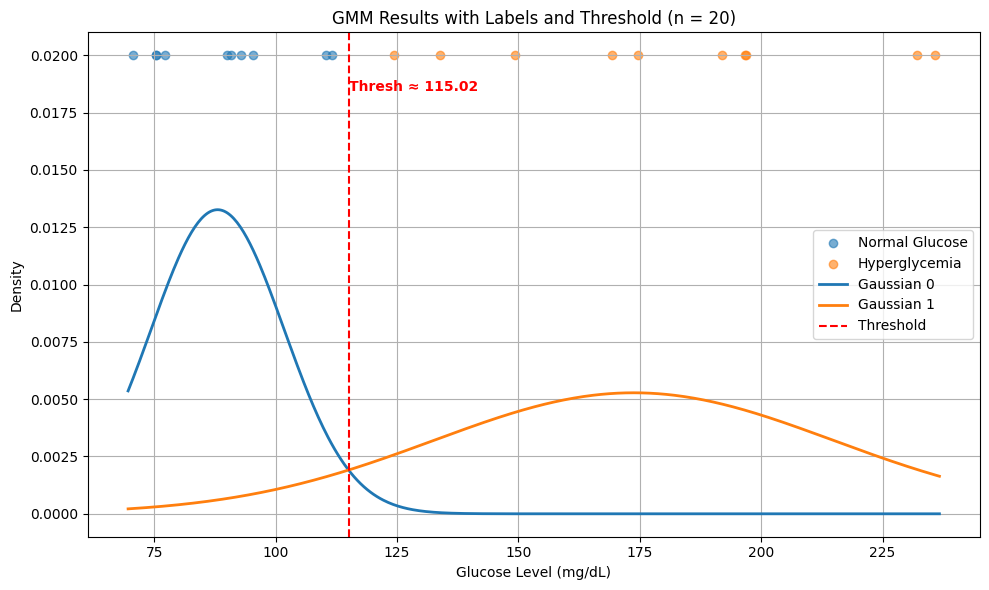

Plotting GMM results for n = 50


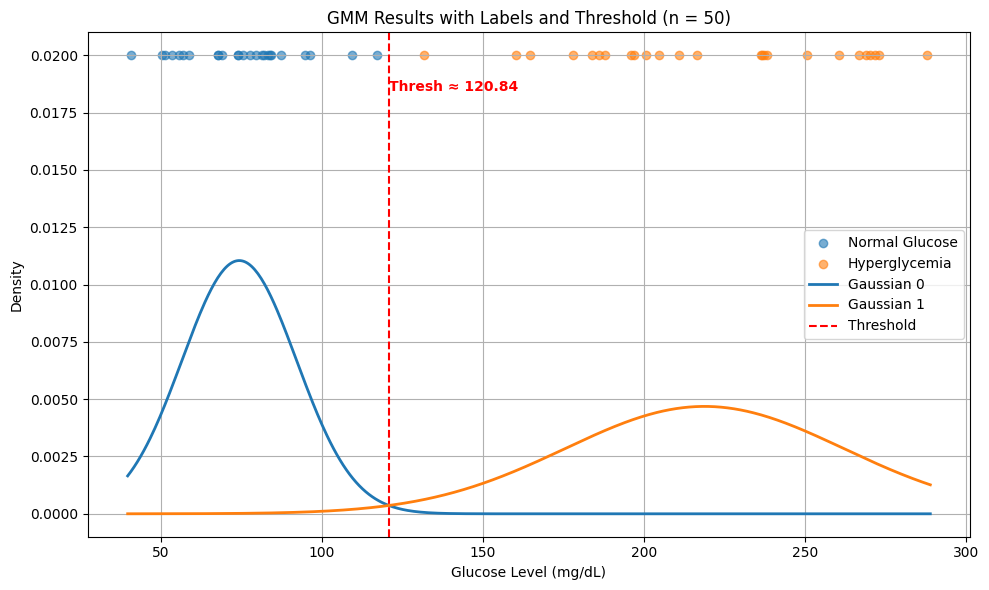

Plotting GMM results for n = 100


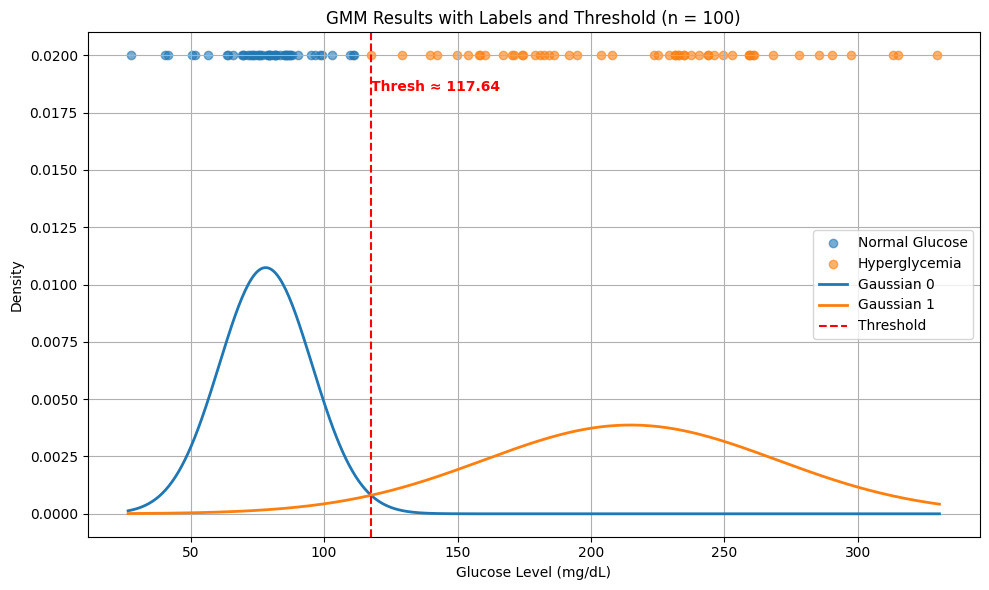

In [45]:
# sample_sizes = [20, 50, 100]

for n in sample_sizes:
    X = datasets[n].flatten()
    
    # Run GMM and get parameters
    means, variances, weights, responsibilities, threshold = run_gmm(X)
    
    # Assign labels from responsibilities
    labels = assign_labels(responsibilities)
    
    # Plot the result
    print(f"Plotting GMM results for n = {n}")
    plot_gmm_results(X, labels, means, variances, weights, threshold)
